In [ ]:
# Initial packages importation 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Metar Data Preprocessing

In [ ]:
# Read the METAR dataset
metar_df = pd.read_parquet('metar_katl.parquet')

In [ ]:
# Show first few rows, dimensions (number of rows and columns), and data types of each column
display(metar_df.head())
print(metar_df.shape)
print(metar_df.dtypes)

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,...,HourlyRelativeHumidity,HourlySkyConditions,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,REM
2,USW00013874,2025-01-01T00:52:00,33.6301,-84.4418,307.8,"ATLANTA HARTSFIELD INTERNATIONAL AIRPORT, GA US",FM-15,343.0,1015.2,0.6,...,56.0,BKN:07 12.19,1015.1,978.1,16.093,5.2,310,11.3,6.7,MET13901/01/25 00:52:02 METAR KATL 010552Z 310...
4,USW00013874,2025-01-01T01:52:00,33.6301,-84.4418,307.8,"ATLANTA HARTSFIELD INTERNATIONAL AIRPORT, GA US",FM-15,343.0,1015.6,0.0,...,56.0,SCT:04 11.58,1015.4,978.4,16.093,4.7,310,13.4,7.7,MET12101/01/25 01:52:02 METAR KATL 010652Z 310...
5,USW00013874,2025-01-01T02:52:00,33.6301,-84.4418,307.8,"ATLANTA HARTSFIELD INTERNATIONAL AIRPORT, GA US",FM-15,343.0,1015.9,0.0,...,61.0,FEW:02 11.58,1015.8,978.8,16.093,4.1,320,NaN,7.2,MET10001/01/25 02:52:02 METAR KATL 010752Z 320...
6,USW00013874,2025-01-01T03:52:00,33.6301,-84.4418,307.8,"ATLANTA HARTSFIELD INTERNATIONAL AIRPORT, GA US",FM-15,343.0,1016.6,0.0,...,63.0,CLR:00,1016.2,979.4,16.093,3.8,320,NaN,5.7,MET10301/01/25 03:52:02 METAR KATL 010852Z 320...
8,USW00013874,2025-01-01T04:52:00,33.6301,-84.4418,307.8,"ATLANTA HARTSFIELD INTERNATIONAL AIRPORT, GA US",FM-15,343.0,1017.3,0.0,...,65.0,CLR:00,1017.2,980.1,16.093,3.5,310,NaN,5.7,MET09701/01/25 04:52:02 METAR KATL 010952Z 310...


(33125, 25)
STATION                       object
DATE                          object
LATITUDE                     float64
LONGITUDE                    float64
ELEVATION                    float64
NAME                          object
REPORT_TYPE                   object
SOURCE                       float64
HourlyAltimeterSetting       float64
HourlyDewPointTemperature    float64
HourlyDryBulbTemperature     float64
HourlyPrecipitation           object
HourlyPresentWeatherType      object
HourlyPressureChange         float64
HourlyPressureTendency       float64
HourlyRelativeHumidity       float64
HourlySkyConditions           object
HourlySeaLevelPressure       float64
HourlyStationPressure        float64
HourlyVisibility              object
HourlyWetBulbTemperature     float64
HourlyWindDirection           object
HourlyWindGustSpeed          float64
HourlyWindSpeed              float64
REM                           object
dtype: object


In [ ]:
# Only consider METAR data points
metar_df_o = metar_df.copy()
metar_df = metar_df[metar_df.iloc[:, -1].astype(str).str[24:29] == 'METAR'] # Take the last column ('REM') and look at char 24-29 for 'METAR'

# Show dimensions (number of rows and columns) of dataset using only METAR data points
metar_df.shape # Reduces from 33125 rows to 27716 rows

(27716, 25)

In [ ]:
# Note: all but 2 METAR data points were taken at the 52nd minute; ignore these two datapoints
len(metar_df[metar_df.iloc[:, 1].astype(str).str[14:16] == '52'])

# Convert DATE column to datetime format
metar_df['weather_datetime'] = pd.to_datetime(metar_df['DATE'])

# Replace trace precipitation with 0.01mm
metar_df['HourlyPrecipitation'] = metar_df['HourlyPrecipitation'].replace('T', '0.01').astype(float)

In [6]:
# See which columns have missing values
nan_columns_idx = np.where(metar_df.isna().sum() != 0)

# Show the columns with missing values
nan_counts = metar_df.isna().sum()
nan_columns = nan_counts.iloc[nan_columns_idx]
nan_columns

HourlyPrecipitation            90
HourlyPresentWeatherType    24847
HourlyPressureChange        18484
HourlyPressureTendency      18484
HourlySkyConditions            10
HourlyStationPressure          36
HourlyVisibility                1
HourlyWetBulbTemperature       36
HourlyWindDirection          1083
HourlyWindGustSpeed         23881
HourlyWindSpeed                 1
dtype: int64

In [ ]:
# Convert HourlyVisibility column from object to numeric data type; non-numeric values will become NaN
metar_df["HourlyVisibility"] = pd.to_numeric(metar_df["HourlyVisibility"], errors="coerce")

# For rows with HourlySkyConditions column value of 'CLR:00' (meaning clear skies), find the maximum HourlyVisibility value
max_v = metar_df.loc[metar_df['HourlySkyConditions']=='CLR:00', 'HourlyVisibility'].max()
print(max_v)

# Fill missing values in HourlyVisibility column with this maximum HourlyVisibility value
metar_df["HourlyVisibility"] = metar_df["HourlyVisibility"].fillna(max_v)

# Fill missing values in HourlyWindSpeed column with 0
metar_df["HourlyWindSpeed"] = metar_df["HourlyWindSpeed"].fillna(0)

16.093


In [ ]:
# Convert HourlySeaLevelPressure and HourlyStationPressure columns to numeric; non-numeric values will become NaN
p1 = "HourlySeaLevelPressure"
p2 = "HourlyStationPressure"


metar_df[p1] = pd.to_numeric(metar_df[p1], errors="coerce")
metar_df[p2] = pd.to_numeric(metar_df[p2], errors="coerce")

# Find the average difference between these columns, excluding rows with missing values
avg_diff = (metar_df[p2] - metar_df[p1]).dropna().mean()

# Find rows where HourlyStationPressure is missing but HourlySeaLevelPressure is available
mask = metar_df[p2].isna() & metar_df[p1].notna()

# For these rows, impute HourlyStationPressure as the HourlySeaLevelPressure value plus the average difference between the columns
metar_df.loc[mask, p2] = metar_df.loc[mask, p1] + avg_diff

In [ ]:
# Convert HourlyDryBulbTemperature and HourlyWetBulbTemperature columns to numeric; non-numeric values will become NaN
p1 = "HourlyDryBulbTemperature"
p2 = "HourlyWetBulbTemperature"


metar_df[p1] = pd.to_numeric(metar_df[p1], errors="coerce")
metar_df[p2] = pd.to_numeric(metar_df[p2], errors="coerce")

# Find the average difference between these columns, excluding rows with missing values
avg_diff = (metar_df[p2] - metar_df[p1]).dropna().mean()

# Find rows where HourlyWetBulbTemperature is missing but HourlyDryBulbTemperature is available
mask = metar_df[p2].isna() & metar_df[p1].notna()

# For these rows, impute HourlyWetBulbTemperature as the HourlyDryBulbTemperature value plus the average difference between the columns
metar_df.loc[mask, p2] = metar_df.loc[mask, p1] + avg_diff

In [ ]:
# Fill missing values in HourlyWindGustSpeed column with 0
metar_df['HourlyWindGustSpeed'] = metar_df['HourlyWindGustSpeed'].fillna(0)

In [ ]:
# Fill missing values in HourlyPrecipitation column with 0
metar_df['HourlyPrecipitation'] = metar_df['HourlyPrecipitation'].fillna(0)

In [12]:
# Create a binary indicator: 1 if wind direction was variable ('VRB'), else 0
metar_df['WindDirection_Variable'] = (metar_df['HourlyWindDirection'] == 'VRB').astype(int)
 
# Convert HourlyWindDirection to numeric; non-numeric values will become NaN
metar_df['HourlyWindDirection'] = pd.to_numeric(metar_df['HourlyWindDirection'], errors="coerce")
 
# Indicate which entries are missing
metar_df["WindDirectionMissing"] = (metar_df['HourlyWindDirection'].isna()).astype(int)
 
# Compute the HourlyWindDirection column median, excluding NaN values
median_wind_dir = metar_df['HourlyWindDirection'].median()
 
# Fill missing values with the column median
metar_df['HourlyWindDirection'] = metar_df['HourlyWindDirection'].fillna(median_wind_dir)

In [ ]:
# Get rid of columns with many missing values
bad_cols = ['HourlyPresentWeatherType', 'HourlyPressureChange', 'HourlyPressureTendency', 'HourlySkyConditions']
metar_df_processed = metar_df.drop(columns=bad_cols)

In [ ]:
# Show final list of columns in the processed METAR dataframe
metar_df_processed.columns

Index(['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME',
       'REPORT_TYPE', 'SOURCE', 'HourlyAltimeterSetting',
       'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity',
       'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility',
       'HourlyWetBulbTemperature', 'HourlyWindDirection',
       'HourlyWindGustSpeed', 'HourlyWindSpeed', 'REM', 'weather_datetime',
       'WindDirection_Variable', 'WindDirectionMissing'],
      dtype='object')

## OTP Dataset Preprocessing

In [ ]:
# Read the On-Time Performance dataset
otp_df = pd.read_parquet('OTP_combined.parquet')

# Show first few rows, dimensions (number of rows and columns), and data types of each column
display(otp_df.head())
print(otp_df.shape)
print(otp_df.dtypes)

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,...,DIV4_WHEELS_OFF,DIV4_TAIL_NUM,DIV5_AIRPORT,DIV5_AIRPORT_ID,DIV5_AIRPORT_SEQ_ID,DIV5_WHEELS_ON,DIV5_TOTAL_GTIME,DIV5_LONGEST_GTIME,DIV5_WHEELS_OFF,DIV5_TAIL_NUM
0,2022,1,1,1,6,1/1/2022 12:00:00 AM,9E,20363,9E,N147PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022,1,1,1,6,1/1/2022 12:00:00 AM,9E,20363,9E,N147PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022,1,1,1,6,1/1/2022 12:00:00 AM,9E,20363,9E,N153PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022,1,1,1,6,1/1/2022 12:00:00 AM,9E,20363,9E,N153PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022,1,1,1,6,1/1/2022 12:00:00 AM,9E,20363,9E,N181GJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(1992511, 109)
YEAR                    int64
QUARTER                 int64
MONTH                   int64
DAY_OF_MONTH            int64
DAY_OF_WEEK             int64
                       ...   
DIV5_WHEELS_ON        float64
DIV5_TOTAL_GTIME      float64
DIV5_LONGEST_GTIME    float64
DIV5_WHEELS_OFF       float64
DIV5_TAIL_NUM         float64
Length: 109, dtype: object


In [16]:
# See which columns have missing values
nan_columns_idx = np.where(otp_df.isna().sum() != 0)

# Show the columns with missing values
nan_counts = otp_df.isna().sum()
nan_columns = nan_counts[nan_counts != 0]
nan_column_names = nan_columns.index
nan_columns

TAIL_NUM                 2839
OP_CARRIER_FL_NUM           1
DEP_TIME                22314
DEP_DELAY               22318
DEP_DELAY_NEW           22318
                       ...   
DIV5_WHEELS_ON        1992511
DIV5_TOTAL_GTIME      1992511
DIV5_LONGEST_GTIME    1992511
DIV5_WHEELS_OFF       1992511
DIV5_TAIL_NUM         1992511
Length: 71, dtype: int64

In [ ]:
# Manually select features that are able to be used in modeling - some columns are derived *after* flight takeoff, whose values would not be able to be used in practical model application
otp_df_o = otp_df.copy()
otp_df = otp_df[['MONTH', 'DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_DEL15', 'DEP_TIME_BLK', 'ARR_DEL15', 'ARR_TIME_BLK', 
             'CRS_ELAPSED_TIME', 'DISTANCE', 'CANCELLED', 'DIVERTED', 'FL_DATE', 'CRS_DEP_TIME', 'CRS_ARR_TIME']]

In [ ]:
# Locate rows that were neither cancelled nor diverted to check for any patterns
test = otp_df.loc[(otp_df['CANCELLED'] == 0) & (otp_df['DIVERTED'] == 0)] # we focus our modeling on completed flights; cancelled/diverted flags imply over 15min delay by definition

# See which columns have missing values
nan_columns_idx = np.where(test.isna().sum() != 0)

# Show the columns with missing values
nan_counts = test.isna().sum()
nan_columns = nan_counts[nan_counts != 0]
nan_column_names = nan_columns.index
nan_columns

Series([], dtype: int64)

In [ ]:
# Convert FL_DATE column to datetime format
otp_df['FL_DATE'] = pd.to_datetime(otp_df['FL_DATE'], format = 'mixed')

# Create a new column that takes the CRS_DEP_TIME column if its origin is ATL, and if not, takes the CRS_ARR_TIME column
otp_df['time_val'] = np.where(otp_df['ORIGIN'] == 'ATL', otp_df['CRS_DEP_TIME'], otp_df['CRS_ARR_TIME'])

# Deal with times that are 3 digits long by padding with a 0 in front
otp_df['time_val'] = otp_df['time_val'].astype(str).str.zfill(4)

# Extract hour and minute from time_val column
otp_df['hour'] = otp_df['time_val'].str.slice(0, 2).astype(int)
otp_df['minute'] = otp_df['time_val'].str.slice(2, 4).astype(int)

# Create flight datetime column
otp_df['flight_datetime'] = (otp_df['FL_DATE'].dt.normalize() +
                             pd.to_timedelta(otp_df['hour'], unit='h') +
                             pd.to_timedelta(otp_df['minute'], unit='m'))

In [20]:
# Sort the dataframes (required for merge_asof)
otp_df_sorted = otp_df.sort_values('flight_datetime')
metar_df_sorted = metar_df_processed.sort_values('weather_datetime')

## Combined Dataset

In [ ]:
# Perform an as-of merge using the flight datetime (from otp_df_sorted) and the weather datetime (from metar_df_sorted)
merged_df = pd.merge_asof(
    otp_df_sorted,
    metar_df_sorted,
    left_on='flight_datetime',
    right_on='weather_datetime',
    direction='nearest'  # Matches the closest record, whether before or after.
)

In [ ]:
# Show first few rows, dimensions (number of rows and columns), and data types of each column
display(merged_df.head())
print(merged_df.shape)
print(merged_df.dtypes)

,MONTH,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,DEP_DEL15,DEP_TIME_BLK,ARR_DEL15,ARR_TIME_BLK,CRS_ELAPSED_TIME,...,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,REM,weather_datetime,WindDirection_Variable,WindDirectionMissing
0,1,6,UA,EWR,ATL,1.0,2100-2159,1.0,0001-0559,153.0,...,977.1,16.093,18.9,200.0,0.0,4.1,MET13201/01/22 00:52:02 METAR KATL 010552Z 200...,2022-01-01 00:52:00,0,0
1,1,6,NK,MSP,ATL,1.0,2000-2059,1.0,0001-0559,167.0,...,977.1,16.093,18.9,200.0,0.0,4.1,MET13201/01/22 00:52:02 METAR KATL 010552Z 200...,2022-01-01 00:52:00,0,0
2,1,6,WN,STL,ATL,0.0,2100-2159,0.0,0001-0559,90.0,...,977.1,16.093,18.9,200.0,0.0,4.1,MET13201/01/22 00:52:02 METAR KATL 010552Z 200...,2022-01-01 00:52:00,0,0
3,1,6,DL,LAX,ATL,1.0,1700-1759,1.0,0001-0559,246.0,...,977.1,16.093,18.9,200.0,0.0,4.1,MET13201/01/22 00:52:02 METAR KATL 010552Z 200...,2022-01-01 00:52:00,0,0
4,1,6,AA,MIA,ATL,0.0,2200-2259,0.0,0001-0559,118.0,...,977.1,16.093,18.9,200.0,0.0,4.1,MET13201/01/22 00:52:02 METAR KATL 010552Z 200...,2022-01-01 00:52:00,0,0


(1992511, 44)
MONTH                                 int64
DAY_OF_WEEK                           int64
OP_CARRIER                           object
ORIGIN                               object
DEST                                 object
DEP_DEL15                           float64
DEP_TIME_BLK                         object
ARR_DEL15                           float64
ARR_TIME_BLK                         object
CRS_ELAPSED_TIME                    float64
DISTANCE                            float64
CANCELLED                           float64
DIVERTED                            float64
FL_DATE                      datetime64[ns]
CRS_DEP_TIME                          int64
CRS_ARR_TIME                          int64
time_val                             object
hour                                  int32
minute                                int32
flight_datetime              datetime64[ns]
STATION                              object
DATE                                 object
LATITUDE          

In [ ]:
# Create a copy of the merged set
flight_delay_dataset = merged_df.copy()

# Create an index column
flight_delay_dataset['flight_id'] = flight_delay_dataset.index
test = flight_delay_dataset.loc[(flight_delay_dataset['CANCELLED'] == 0) & (flight_delay_dataset['DIVERTED'] == 0)]

# Find the columns with missing values
nan_counts = test.isna().sum()
nan_columns = nan_counts[nan_counts != 0]
nan_column_names = nan_columns.index

# If we were to remove all rows with any missing values in the columns shown above, what percent of the data would it be?
rows_with_nan_mask = test[nan_column_names].isna().any(axis=1)

percent_removed = rows_with_nan_mask.sum()/len(test)
percent_removed # None, provided we exclude cancelled and diverted flights from modeling task (can be part of prediction task)

0.0

In [ ]:
try:
    # Add an index column to both full and filtered datasets so we can count flights per route
    flight_delay_dataset['index'] = flight_delay_dataset.index
    test['index'] = test.index

    # Count total flights (including cancelled/diverted) for each origin–destination pair
    test2 = flight_delay_dataset.groupby(by = ['ORIGIN', 'DEST'])['index'].count().reset_index().rename(columns = {'index' : 'num_flights'})

    # Count only completed flights (neither cancelled nor diverted) per route
    test3 = test.groupby(by = ['ORIGIN', 'DEST'])['index'].count().reset_index().rename(columns = {'index' : 'num_filtered_flights'})
    
    # Merge the two counts so we can compare total vs. completed flights on each route
    test4 = test2.merge(test3, on = ['ORIGIN','DEST'], how = 'inner')

    # Compute the difference - how many flights were cancelled or diverted per route?
    test4['diff'] = test4['num_flights'] - test4['num_filtered_flights']
    
    # Create a route column for presentation
    test4['route'] = test4['ORIGIN'] + ', ' + test4['DEST']

    # Extract just the route identifier and the difference count
    test5 = test4[['route', 'diff']].copy()

    # Optionally keep full and simplified copies for further exploration
    problematic_flights = test4.copy()
    problematic_flights_simplified = test5.copy()

    # Clean up intermediate sets to free memory
    del test,test2,test3,test4,test5
except:
    print('still good; test cases still gone')

C:\Users\Yusuf\AppData\Local\Temp\ipykernel_30336\804180084.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['index'] = test.index


In [ ]:
# Identification of most affected routes by exclusion of cancellations and diversions from flight delay logic. 
display(problematic_flights.head())

print("Top 25 problematic routes")
display(problematic_flights_simplified.sort_values(by = 'diff', ascending= False).head(25))

print("Least 25 problematic routes")
display(problematic_flights_simplified.sort_values(by = 'diff', ascending= True).head(25))

,ORIGIN,DEST,num_flights,num_filtered_flights,diff,route
0,ABE,ATL,2910,2876,34,"ABE, ATL"
1,ABQ,ATL,3028,2996,32,"ABQ, ATL"
2,ABY,ATL,2542,2526,16,"ABY, ATL"
3,ACY,ATL,109,109,0,"ACY, ATL"
4,AEX,ATL,2455,2431,24,"AEX, ATL"


Top 25 problematic routes


,route,diff
94,"ATL, LGA",693
246,"LGA, ATL",619
59,"ATL, EWR",573
211,"EWR, ATL",506
97,"ATL, MCO",434
51,"ATL, DFW",416
249,"MCO, ATL",408
49,"ATL, DCA",382
201,"DCA, ATL",375
203,"DFW, ATL",365


Least 25 problematic routes


,route,diff
309,"SWF, ATL",0
3,"ACY, ATL",0
267,"OGG, ATL",0
294,"SCE, ATL",0
142,"ATL, SCE",0
165,"ATL, TVC",1
287,"RST, ATL",1
115,"ATL, OGG",1
157,"ATL, SWF",1
135,"ATL, RST",1


In [ ]:
# Show all columns in flight_delay_dataset
flight_delay_dataset.columns

Index(['MONTH', 'DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_DEL15',
       'DEP_TIME_BLK', 'ARR_DEL15', 'ARR_TIME_BLK', 'CRS_ELAPSED_TIME',
       'DISTANCE', 'CANCELLED', 'DIVERTED', 'FL_DATE', 'CRS_DEP_TIME',
       'CRS_ARR_TIME', 'time_val', 'hour', 'minute', 'flight_datetime',
       'STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME',
       'REPORT_TYPE', 'SOURCE', 'HourlyAltimeterSetting',
       'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity',
       'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility',
       'HourlyWetBulbTemperature', 'HourlyWindDirection',
       'HourlyWindGustSpeed', 'HourlyWindSpeed', 'REM', 'weather_datetime',
       'WindDirection_Variable', 'WindDirectionMissing', 'flight_id', 'index'],
      dtype='object')

In [ ]:
# Manually select columns to include in modeling
good_cols = ['MONTH', 'DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_DEL15',
       'DEP_TIME_BLK', 'ARR_DEL15', 'ARR_TIME_BLK', 'CRS_ELAPSED_TIME',
       'DISTANCE', 'CANCELLED', 'DIVERTED', 'FL_DATE', 'CRS_DEP_TIME',
       'CRS_ARR_TIME', 'HourlyAltimeterSetting',
       'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity',
       'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility',
       'HourlyWetBulbTemperature', 'HourlyWindDirection',
       'HourlyWindGustSpeed', 'HourlyWindSpeed',
       'WindDirection_Variable', 'WindDirectionMissing', 'flight_id']
flight_delay_dataset = flight_delay_dataset[good_cols]

## Model Dataset Preprocessing

In [ ]:
# Create a set to use for modeling
fd_model_data = flight_delay_dataset.copy()
fd_model_data = fd_model_data.loc[(fd_model_data['CANCELLED'] == 0) & (fd_model_data['DIVERTED'] == 0)]
unnecessary_cols = ['FL_DATE', 'CANCELLED', 'DIVERTED']
fd_model_data = fd_model_data.drop(columns=unnecessary_cols)
fd_model_data.dtypes

MONTH                          int64
DAY_OF_WEEK                    int64
OP_CARRIER                    object
ORIGIN                        object
DEST                          object
DEP_DEL15                    float64
DEP_TIME_BLK                  object
ARR_DEL15                    float64
ARR_TIME_BLK                  object
CRS_ELAPSED_TIME             float64
DISTANCE                     float64
CRS_DEP_TIME                   int64
CRS_ARR_TIME                   int64
HourlyAltimeterSetting       float64
HourlyDewPointTemperature    float64
HourlyDryBulbTemperature     float64
HourlyPrecipitation          float64
HourlyRelativeHumidity       float64
HourlySeaLevelPressure       float64
HourlyStationPressure        float64
HourlyVisibility             float64
HourlyWetBulbTemperature     float64
HourlyWindDirection          float64
HourlyWindGustSpeed          float64
HourlyWindSpeed              float64
WindDirection_Variable         int32
WindDirectionMissing           int32
f

In [ ]:
# Extract hour values from the scheduled hour to use in model
fd_model_data['DEP_HOUR'] = fd_model_data['DEP_TIME_BLK'].str.slice(0, 2).astype(int)
fd_model_data = fd_model_data.drop(columns=['DEP_TIME_BLK'])

fd_model_data['ARR_HOUR'] = fd_model_data['ARR_TIME_BLK'].str.slice(0, 2).astype(int)
fd_model_data = fd_model_data.drop(columns=['ARR_TIME_BLK'])

# Perform cyclical encoding for MONTH, DEP_HOUR, and ARR_HOUR columns 
fd_model_data['month_sin'] = np.sin(2 * np.pi * fd_model_data['MONTH'] / 12)
fd_model_data['month_cos'] = np.cos(2 * np.pi * fd_model_data['MONTH'] / 12)
fd_model_data = fd_model_data.drop(columns=['MONTH'])

fd_model_data['dep_hour_sin'] = np.sin(2 * np.pi * fd_model_data['DEP_HOUR'] / 24)
fd_model_data['dep_hour_cos'] = np.cos(2 * np.pi * fd_model_data['DEP_HOUR'] / 24)
fd_model_data = fd_model_data.drop(columns=['DEP_HOUR'])

fd_model_data['arr_hour_sin'] = np.sin(2 * np.pi * fd_model_data['ARR_HOUR'] / 24)
fd_model_data['arr_hour_cos'] = np.cos(2 * np.pi * fd_model_data['ARR_HOUR'] / 24)
fd_model_data = fd_model_data.drop(columns=['ARR_HOUR'])

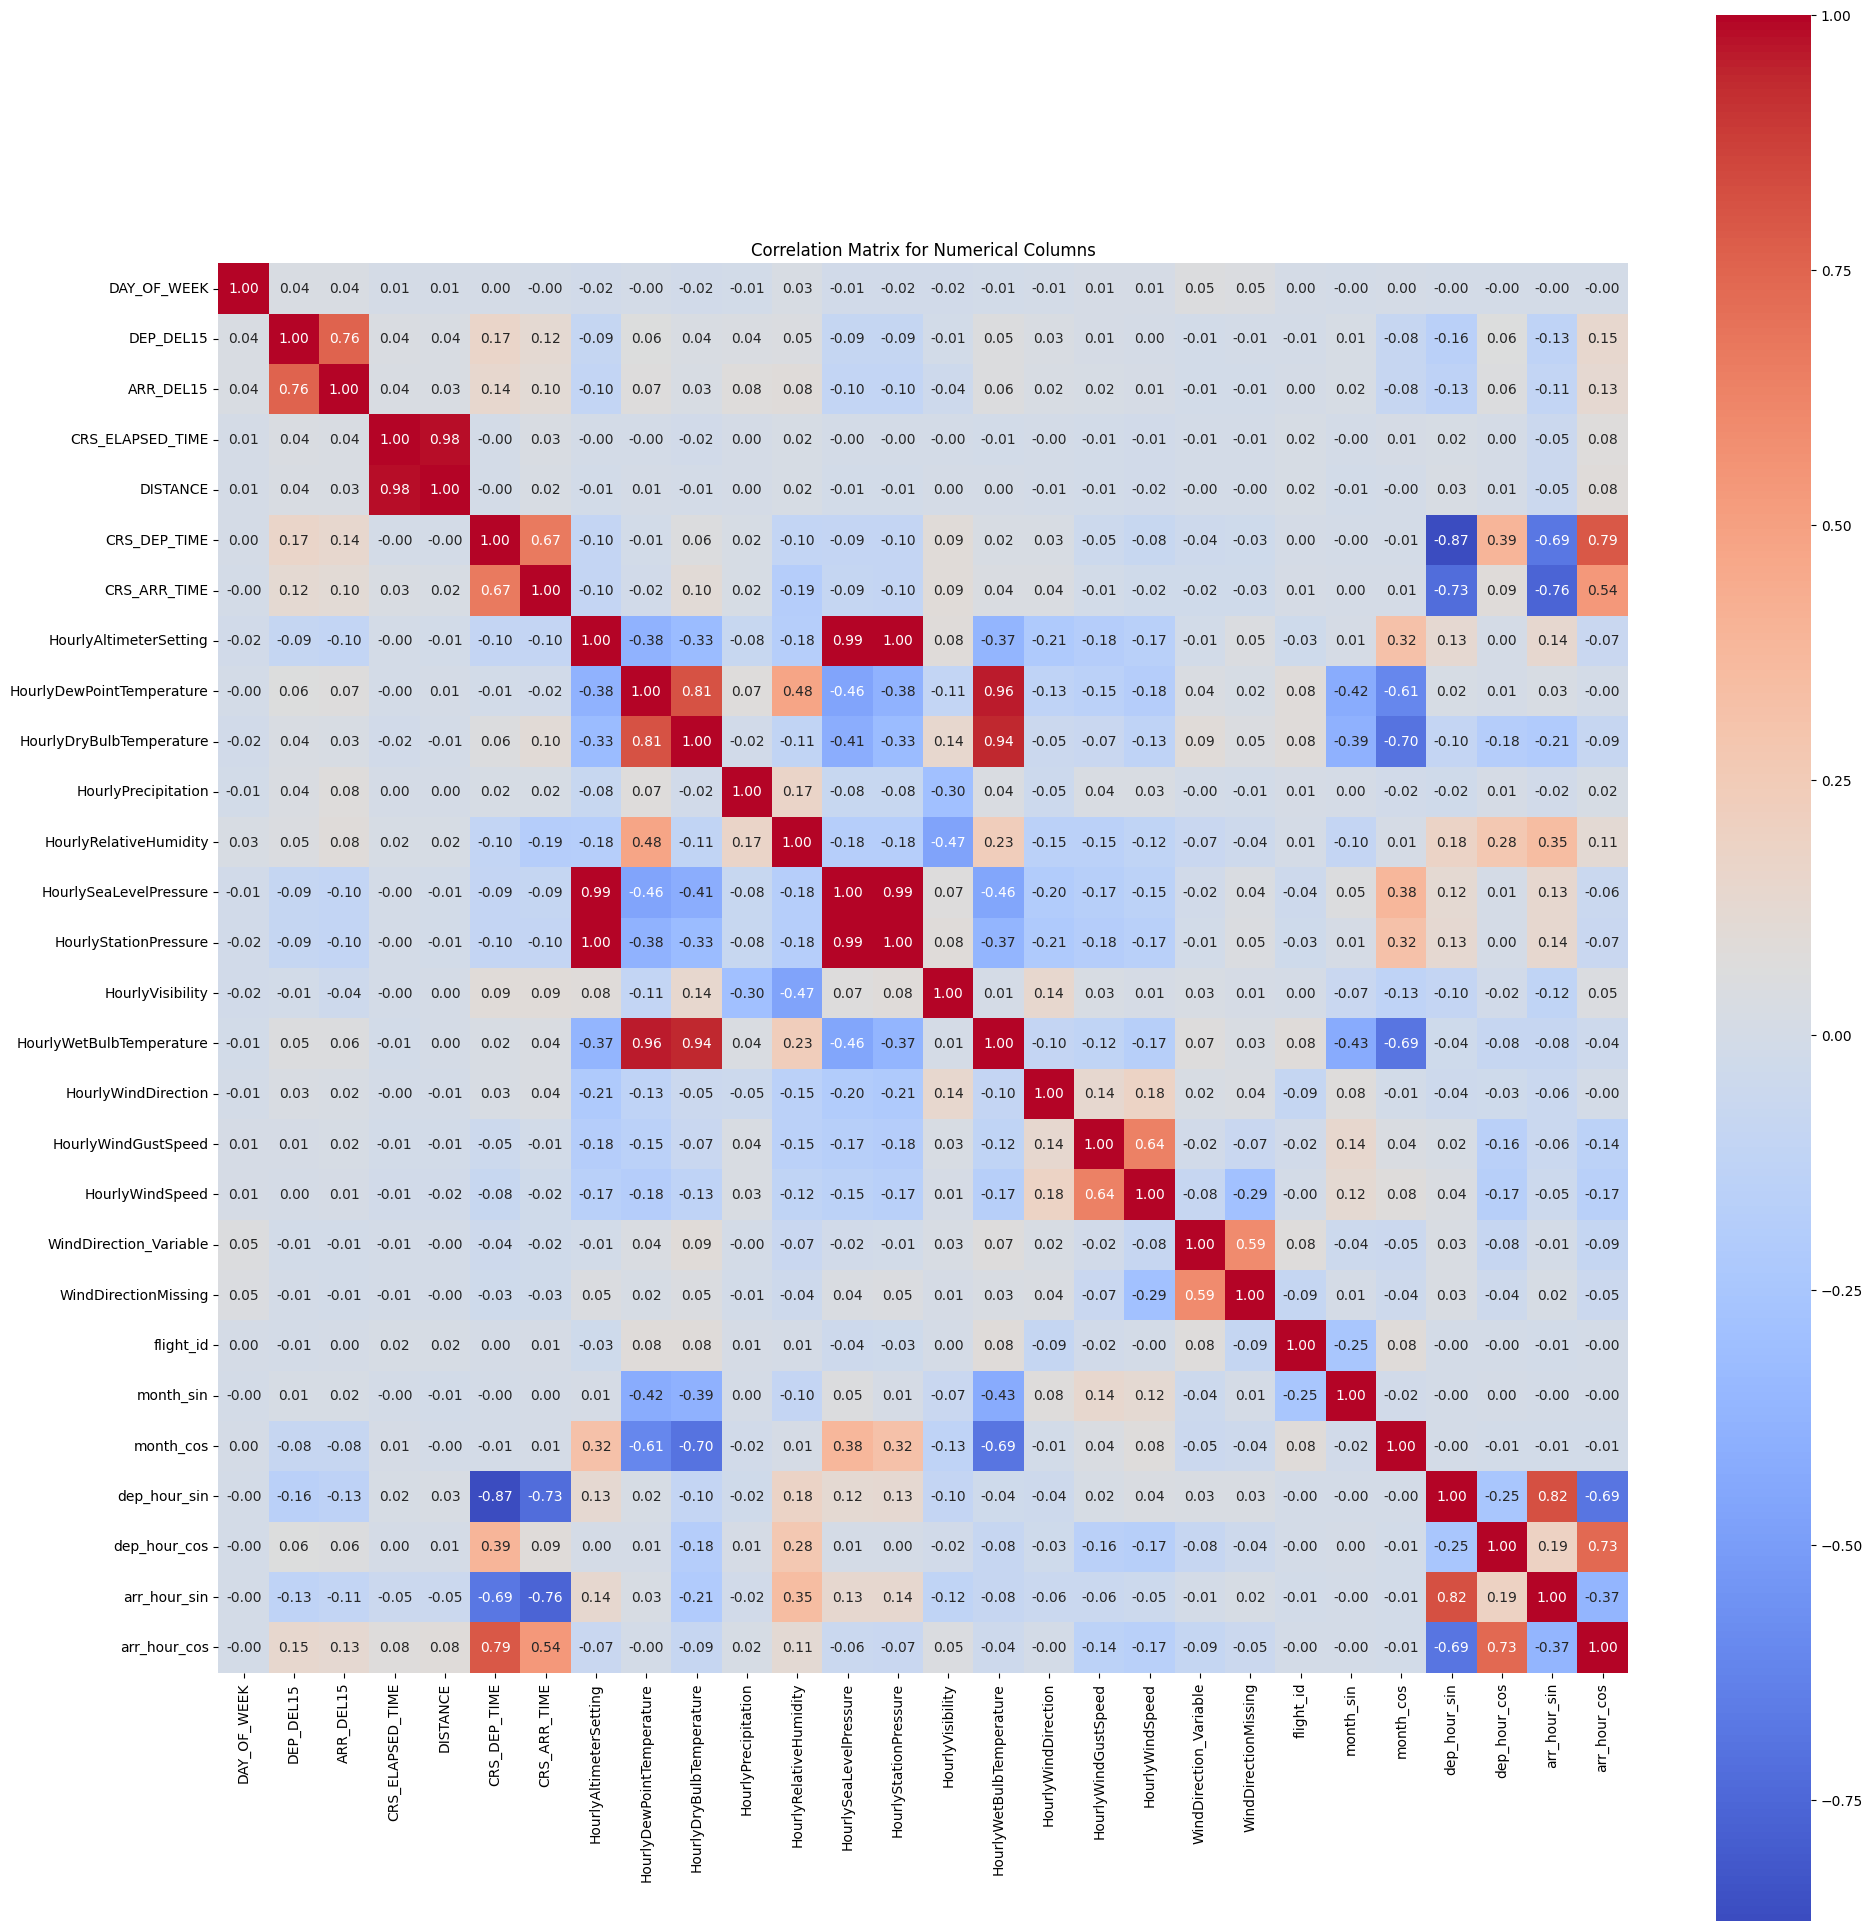

In [30]:
# Show correlation matrix for numerical columns
numeric = fd_model_data.select_dtypes(include=[np.number]).dropna()
corr_matrix = numeric.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix for Numerical Columns")
plt.tight_layout()
plt.show()

In [ ]:
# Huge correlation between temperatures - drop HourlyDewPointTemperature and HourlyWetBulbTemperature column, but keep HourlyDryBulbTemperature
temp_cols = ['HourlyDewPointTemperature','HourlyWetBulbTemperature']
fd_model_data = fd_model_data.drop(columns=temp_cols)

In [ ]:
# Split data into ATL departures and arrivals

# These are the sets to be used in training
atl_deps_model = fd_model_data[fd_model_data['ORIGIN']=='ATL']
atl_arrs_model = fd_model_data[fd_model_data['DEST']=='ATL']

# These are the sets to be used in testing, including cancellations and diversions
atl_deps_complete = flight_delay_dataset[flight_delay_dataset['ORIGIN']=='ATL']
atl_arrs_complete = flight_delay_dataset[flight_delay_dataset['DEST']=='ATL']

# Make copies of the complete datasets
atl_deps_complete_o = atl_deps_complete.copy()
atl_arrs_complete_o = atl_arrs_complete.copy()

In [ ]:
# Show first few rows, dimensions (number of rows and columns), and names of columns
display(atl_deps_model.head())
print(atl_deps_model.shape)
print(atl_deps_model.columns)

display(atl_arrs_model.head())
print(atl_arrs_model.shape)
print(atl_arrs_model.columns)

,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,DEP_DEL15,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_TIME,CRS_ARR_TIME,...,HourlyWindSpeed,WindDirection_Variable,WindDirectionMissing,flight_id,month_sin,month_cos,dep_hour_sin,dep_hour_cos,arr_hour_sin,arr_hour_cos
9,6,AA,ATL,MIA,0.0,0.0,120.0,594.0,515,715,...,4.6,0,0,9,0.5,0.866025,0.0,1.000000e+00,0.965926,-0.258819
10,6,NK,ATL,FLL,1.0,0.0,117.0,581.0,520,717,...,4.6,0,0,10,0.5,0.866025,0.0,1.000000e+00,0.965926,-0.258819
13,6,NK,ATL,MCO,0.0,0.0,100.0,404.0,530,710,...,3.6,0,0,13,0.5,0.866025,0.0,1.000000e+00,0.965926,-0.258819
14,6,B6,ATL,FLL,0.0,0.0,111.0,581.0,549,740,...,3.6,0,0,14,0.5,0.866025,0.0,1.000000e+00,0.965926,-0.258819
15,6,NK,ATL,LAX,1.0,1.0,287.0,1947.0,600,747,...,3.6,0,0,15,0.5,0.866025,1.0,6.123234e-17,0.965926,-0.258819


(982873, 29)
Index(['DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_DEL15', 'ARR_DEL15',
       'CRS_ELAPSED_TIME', 'DISTANCE', 'CRS_DEP_TIME', 'CRS_ARR_TIME',
       'HourlyAltimeterSetting', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity',
       'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility',
       'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed',
       'WindDirection_Variable', 'WindDirectionMissing', 'flight_id',
       'month_sin', 'month_cos', 'dep_hour_sin', 'dep_hour_cos',
       'arr_hour_sin', 'arr_hour_cos'],
      dtype='object')


,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,DEP_DEL15,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_TIME,CRS_ARR_TIME,...,HourlyWindSpeed,WindDirection_Variable,WindDirectionMissing,flight_id,month_sin,month_cos,dep_hour_sin,dep_hour_cos,arr_hour_sin,arr_hour_cos
0,6,UA,EWR,ATL,1.0,1.0,153.0,746.0,2129,2,...,4.1,0,0,0,0.5,0.866025,-0.707107,0.707107,0.0,1.0
1,6,NK,MSP,ATL,1.0,1.0,167.0,907.0,2025,12,...,4.1,0,0,1,0.5,0.866025,-0.866025,0.500000,0.0,1.0
2,6,WN,STL,ATL,0.0,0.0,90.0,484.0,2145,15,...,4.1,0,0,2,0.5,0.866025,-0.707107,0.707107,0.0,1.0
3,6,DL,LAX,ATL,1.0,1.0,246.0,1947.0,1713,19,...,4.1,0,0,3,0.5,0.866025,-0.965926,-0.258819,0.0,1.0
4,6,AA,MIA,ATL,0.0,0.0,118.0,594.0,2222,20,...,4.1,0,0,4,0.5,0.866025,-0.500000,0.866025,0.0,1.0


(982876, 29)
Index(['DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_DEL15', 'ARR_DEL15',
       'CRS_ELAPSED_TIME', 'DISTANCE', 'CRS_DEP_TIME', 'CRS_ARR_TIME',
       'HourlyAltimeterSetting', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity',
       'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility',
       'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed',
       'WindDirection_Variable', 'WindDirectionMissing', 'flight_id',
       'month_sin', 'month_cos', 'dep_hour_sin', 'dep_hour_cos',
       'arr_hour_sin', 'arr_hour_cos'],
      dtype='object')


In [ ]:
# Show data types of all columns in departures set
print(atl_deps_model.dtypes)

DAY_OF_WEEK                   int64
OP_CARRIER                   object
ORIGIN                       object
DEST                         object
DEP_DEL15                   float64
ARR_DEL15                   float64
CRS_ELAPSED_TIME            float64
DISTANCE                    float64
CRS_DEP_TIME                  int64
CRS_ARR_TIME                  int64
HourlyAltimeterSetting      float64
HourlyDryBulbTemperature    float64
HourlyPrecipitation         float64
HourlyRelativeHumidity      float64
HourlySeaLevelPressure      float64
HourlyStationPressure       float64
HourlyVisibility            float64
HourlyWindDirection         float64
HourlyWindGustSpeed         float64
HourlyWindSpeed             float64
WindDirection_Variable        int32
WindDirectionMissing          int32
flight_id                     int64
month_sin                   float64
month_cos                   float64
dep_hour_sin                float64
dep_hour_cos                float64
arr_hour_sin                

In [ ]:
# Show data types of all columns in arrivals set
print(atl_arrs_model.dtypes)

DAY_OF_WEEK                   int64
OP_CARRIER                   object
ORIGIN                       object
DEST                         object
DEP_DEL15                   float64
ARR_DEL15                   float64
CRS_ELAPSED_TIME            float64
DISTANCE                    float64
CRS_DEP_TIME                  int64
CRS_ARR_TIME                  int64
HourlyAltimeterSetting      float64
HourlyDryBulbTemperature    float64
HourlyPrecipitation         float64
HourlyRelativeHumidity      float64
HourlySeaLevelPressure      float64
HourlyStationPressure       float64
HourlyVisibility            float64
HourlyWindDirection         float64
HourlyWindGustSpeed         float64
HourlyWindSpeed             float64
WindDirection_Variable        int32
WindDirectionMissing          int32
flight_id                     int64
month_sin                   float64
month_cos                   float64
dep_hour_sin                float64
dep_hour_cos                float64
arr_hour_sin                

In [ ]:
# Columns to be dropped
extra_cols = ['FL_DATE', 'CANCELLED', 'DIVERTED', 'HourlyDewPointTemperature','HourlyWetBulbTemperature']
atl_deps_complete = atl_deps_complete.drop(columns=extra_cols)

# Extract hour values from the scheduled hour blocks to use in model
atl_deps_complete['DEP_HOUR'] = atl_deps_complete['DEP_TIME_BLK'].str.slice(0, 2).astype(int)
atl_deps_complete = atl_deps_complete.drop(columns=['DEP_TIME_BLK'])

atl_deps_complete['ARR_HOUR'] = atl_deps_complete['ARR_TIME_BLK'].str.slice(0, 2).astype(int)
atl_deps_complete = atl_deps_complete.drop(columns=['ARR_TIME_BLK'])

# Perform cyclical encoding for MONTH, DEP_HOUR, and ARR_HOUR columns 
atl_deps_complete['month_sin'] = np.sin(2 * np.pi * atl_deps_complete['MONTH'] / 12)
atl_deps_complete['month_cos'] = np.cos(2 * np.pi * atl_deps_complete['MONTH'] / 12)
atl_deps_complete = atl_deps_complete.drop(columns=['MONTH'])

atl_deps_complete['dep_hour_sin'] = np.sin(2 * np.pi * atl_deps_complete['DEP_HOUR'] / 24)
atl_deps_complete['dep_hour_cos'] = np.cos(2 * np.pi * atl_deps_complete['DEP_HOUR'] / 24)
atl_deps_complete = atl_deps_complete.drop(columns=['DEP_HOUR'])

atl_deps_complete['arr_hour_sin'] = np.sin(2 * np.pi * atl_deps_complete['ARR_HOUR'] / 24)
atl_deps_complete['arr_hour_cos'] = np.cos(2 * np.pi * atl_deps_complete['ARR_HOUR'] / 24)
atl_deps_complete = atl_deps_complete.drop(columns=['ARR_HOUR'])

# Do the same for arrivals
atl_arrs_complete = atl_arrs_complete.drop(columns=extra_cols)

# Extract hour values from the scheduled hour blocks to use in model
atl_arrs_complete['DEP_HOUR'] = atl_arrs_complete['DEP_TIME_BLK'].str.slice(0, 2).astype(int)
atl_arrs_complete = atl_arrs_complete.drop(columns=['DEP_TIME_BLK'])

atl_arrs_complete['ARR_HOUR'] = atl_arrs_complete['ARR_TIME_BLK'].str.slice(0, 2).astype(int)
atl_arrs_complete = atl_arrs_complete.drop(columns=['ARR_TIME_BLK'])

# Perform cyclical encoding for MONTH, DEP_HOUR, and ARR_HOUR columns 
atl_arrs_complete['month_sin'] = np.sin(2 * np.pi * atl_arrs_complete['MONTH'] / 12)
atl_arrs_complete['month_cos'] = np.cos(2 * np.pi * atl_arrs_complete['MONTH'] / 12)
atl_arrs_complete = atl_arrs_complete.drop(columns=['MONTH'])

atl_arrs_complete['dep_hour_sin'] = np.sin(2 * np.pi * atl_arrs_complete['DEP_HOUR'] / 24)
atl_arrs_complete['dep_hour_cos'] = np.cos(2 * np.pi * atl_arrs_complete['DEP_HOUR'] / 24)
atl_arrs_complete = atl_arrs_complete.drop(columns=['DEP_HOUR'])

atl_arrs_complete['arr_hour_sin'] = np.sin(2 * np.pi * atl_arrs_complete['ARR_HOUR'] / 24)
atl_arrs_complete['arr_hour_cos'] = np.cos(2 * np.pi * atl_arrs_complete['ARR_HOUR'] / 24)
atl_arrs_complete = atl_arrs_complete.drop(columns=['ARR_HOUR'])

In [ ]:
# Drop ORIGIN and DEST for both departures and arrivals
drop_dest_orig = ['ORIGIN', 'DEST']
atl_deps_model = atl_deps_model.drop(columns=drop_dest_orig)
atl_deps_complete = atl_deps_complete.drop(columns=drop_dest_orig)
atl_arrs_model = atl_arrs_model.drop(columns=drop_dest_orig)
atl_arrs_complete = atl_arrs_complete.drop(columns=drop_dest_orig)

In [ ]:
# Define categorical columns for one-hot encoding
dep_cat_cols = ['DAY_OF_WEEK', 'OP_CARRIER']
arr_cat_cols = ['DAY_OF_WEEK', 'OP_CARRIER']

# Proceed with one-hot encoding
atl_deps_model_e = pd.get_dummies(atl_deps_model, columns=dep_cat_cols, drop_first=True)
atl_arrs_model_e = pd.get_dummies(atl_arrs_model, columns=arr_cat_cols, drop_first=True)

atl_deps_complete_e = pd.get_dummies(atl_deps_complete, columns=dep_cat_cols, drop_first=True)
atl_arrs_complete_e = pd.get_dummies(atl_arrs_complete, columns=arr_cat_cols, drop_first=True)

## Model Training

In [ ]:
# Separate the predictor variables from the response variable
atl_deps_X = atl_deps_model_e.drop(columns=['DEP_DEL15','ARR_DEL15','flight_id'], axis=1)
atl_deps_y = atl_deps_model_e['DEP_DEL15']
atl_deps_id = atl_deps_model_e['flight_id']

atl_arrs_X = atl_arrs_model_e.drop(columns=['DEP_DEL15','ARR_DEL15','flight_id'], axis=1)
atl_arrs_y = atl_arrs_model_e['ARR_DEL15']
atl_arrs_id = atl_arrs_model_e['flight_id']

from sklearn.model_selection import train_test_split

# Split the data into train and test data, using a 80/20 split (will perform cross-validation later)
atl_deps_X_train, atl_deps_X_test, atl_deps_y_train, atl_deps_y_test, atl_deps_id_train, atl_deps_id_test  = train_test_split(atl_deps_X, atl_deps_y, atl_deps_id, test_size=0.2, stratify=atl_deps_y, random_state=6242)

atl_arrs_X_train, atl_arrs_X_test, atl_arrs_y_train, atl_arrs_y_test, atl_arrs_id_train, atl_arrs_id_test = train_test_split(atl_arrs_X, atl_arrs_y, atl_arrs_id, test_size=0.2, stratify=atl_arrs_y, random_state=6242)

In [ ]:
# Show predictor variables for departure set, after one-hot encoding
atl_deps_X_train.columns

Index(['CRS_ELAPSED_TIME', 'DISTANCE', 'CRS_DEP_TIME', 'CRS_ARR_TIME',
       'HourlyAltimeterSetting', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity',
       'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility',
       'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed',
       'WindDirection_Variable', 'WindDirectionMissing', 'month_sin',
       'month_cos', 'dep_hour_sin', 'dep_hour_cos', 'arr_hour_sin',
       'arr_hour_cos', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4',
       'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7', 'OP_CARRIER_AA',
       'OP_CARRIER_AS', 'OP_CARRIER_B6', 'OP_CARRIER_DL', 'OP_CARRIER_F9',
       'OP_CARRIER_MQ', 'OP_CARRIER_NK', 'OP_CARRIER_OH', 'OP_CARRIER_OO',
       'OP_CARRIER_UA', 'OP_CARRIER_WN', 'OP_CARRIER_YV', 'OP_CARRIER_YX'],
      dtype='object')

## Random Search CV

If using joblib, run all cells before this one.

In [ ]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve
RandomizedSearchCV
from sklearn.metrics import (confusion_matrix, recall_score, classification_report, precision_score,
                              accuracy_score, roc_auc_score, average_precision_score, make_scorer, roc_curve)

# Define a custom KS score function
def ks_score(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    return max(tpr - fpr)
# Add KS score as a scorer
ks_scorer = make_scorer(ks_score, needs_proba=True)

# Define the parameter grid to search
param_distributions = {
    "n_estimators": [25,50,100,150,200],
    "max_depth": [5,10,15,20,25],
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(3, 10),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

c:\Users\Yusuf\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [ ]:
# Take a stratified random sample of the departures training set
atl_deps_X_sample, _, atl_deps_y_sample, _ = train_test_split(
    atl_deps_X_train,
    atl_deps_y_train,
    train_size=0.15,
    stratify=atl_deps_y_train,   
    random_state=6242
)

print("Sample size:", atl_deps_X_sample.shape[0])

Sample size: 117944


In [ ]:
#from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Initialize the Random Forest model, with balanced class weights
rf_dep_base = RandomForestClassifier(class_weight="balanced", random_state=6242)

#Pipeline([
  #  ("smote", SMOTE(random_state=6242)),
 #   ("rf", RandomForestClassifier(class_weight="balanced_subsample", random_state=6242))
#])

# Define multiple scoring metrics to evaluate during hyperparameter search
scoring = {
    "roc_auc":   "roc_auc",
    "precision": "precision",
    "recall":    "recall",
    "f1":        "f1"
}


# Setup a randomized hyperparameter search with 20 iterations and 5-fold cross-validation
random_search_dep = RandomizedSearchCV(
    estimator=rf_dep_base,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    scoring=scoring,
    refit= 'roc_auc',
    random_state=6242,
    n_jobs=-1,
    verbose = 4
)

# Fit on the training data and display the best hyperparameter combination
random_search_dep.fit(atl_deps_X_sample, atl_deps_y_sample)
print(random_search_dep.best_params_)

# Extract and display the best-performing pipeline
rf_dep_model = random_search_dep.best_estimator_
print(rf_dep_model)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 6, 'min_samples_split': 9, 'n_estimators': 150}
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=25, min_samples_leaf=6, min_samples_split=9,
                       n_estimators=150, random_state=6242)


In [ ]:
# Refit the finalized pipeline on the entire training set so the model can learn from all available data, not just the sample.
rf_dep_model.fit(atl_deps_X_train,atl_deps_y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=25, min_samples_leaf=6, min_samples_split=9,
                       n_estimators=150, random_state=6242)

In [ ]:
# Save model to files
import joblib
from joblib import dump, load
joblib.dump(rf_dep_model,'rf_dep_model.joblib')

['rf_dep_model.joblib']

In [ ]:
# Load the locally saved model, assuming it is saved
import joblib
from joblib import dump, load
import os
path = "rf_dep_model.joblib"


try:
    rf_dep_model
    print('model exists')
except NameError:
    
    if os.path.exists(path):
        rf_dep_model = load(path)
        print(f"Loaded model from {path}")
    else:
        raise FileNotFoundError(f"No model file found at {path}")

model exists


Departure Delay Prediction Metrics:
Accuracy: 0.7711
Precision: 0.4341
Recall: 0.4811
ROC AUC: 0.7318
PR AUC: 0.4678

Detailed Classification Report for Departures:
              precision    recall  f1-score   support

         0.0       0.87      0.84      0.86    157316
         1.0       0.43      0.48      0.46     39259

    accuracy                           0.77    196575
   macro avg       0.65      0.66      0.66    196575
weighted avg       0.78      0.77      0.78    196575

KS Score for Departure Delay Predictions: 0.3459


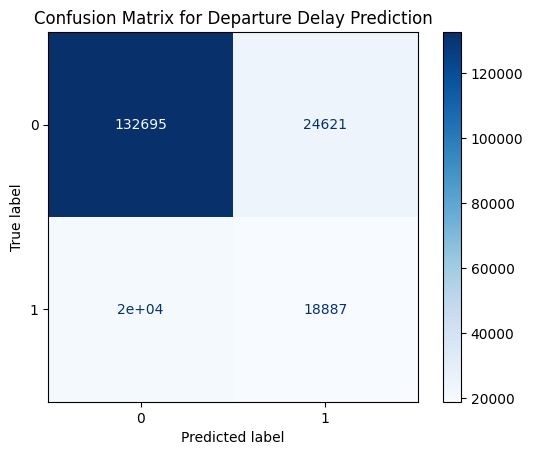

In [ ]:
# Predict probabilities and classes on the test sets
dep_y_pred_proba = rf_dep_model.predict_proba(atl_deps_X_test)
dep_delay_probabilities = dep_y_pred_proba[:, 1]
dep_y_pred = rf_dep_model.predict(atl_deps_X_test)

# Evaluate the model using accuracy, precision, recall, ROC AUC, and PR AUC
# Departures
dep_accuracy = accuracy_score(atl_deps_y_test, dep_y_pred)
dep_precision = precision_score(atl_deps_y_test, dep_y_pred)
dep_recall = recall_score(atl_deps_y_test, dep_y_pred)
dep_roc_auc = roc_auc_score(atl_deps_y_test, dep_delay_probabilities)
dep_pr_auc = average_precision_score(atl_deps_y_test, dep_delay_probabilities)

# Create confusion matrix
dep_cm = confusion_matrix(atl_deps_y_test, dep_y_pred)

# Print results
print("Departure Delay Prediction Metrics:")
print(f"Accuracy: {dep_accuracy:.4f}")
print(f"Precision: {dep_precision:.4f}")
print(f"Recall: {dep_recall:.4f}")
print(f"ROC AUC: {dep_roc_auc:.4f}")
print(f"PR AUC: {dep_pr_auc:.4f}")
print("\nDetailed Classification Report for Departures:")
print(classification_report(atl_deps_y_test, dep_y_pred))

# Calculate KS score for departure delay predictions
dep_ks_score = ks_score(atl_deps_y_test, dep_delay_probabilities)

# Print the KS score
print(f"KS Score for Departure Delay Predictions: {dep_ks_score:.4f}")

from sklearn.metrics import ConfusionMatrixDisplay

# Visualize the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=dep_cm).plot(cmap='Blues')
plt.title("Confusion Matrix for Departure Delay Prediction")
plt.show()



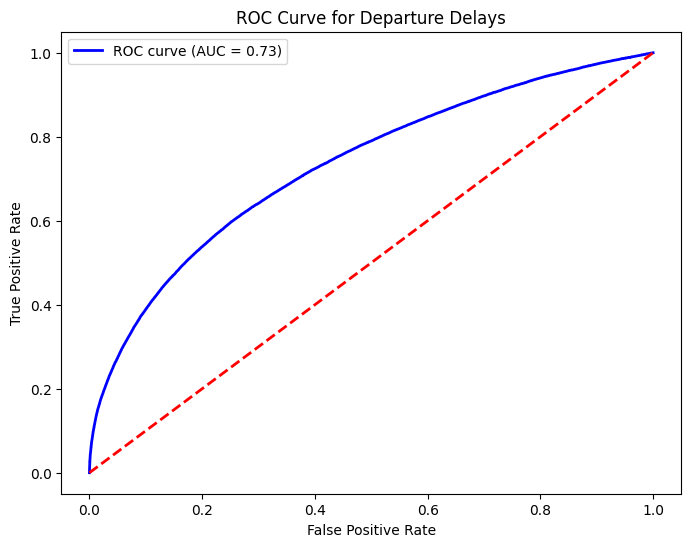

In [48]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(atl_deps_y_test, dep_delay_probabilities)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {dep_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Departure Delays')
plt.legend(loc="best")
plt.show()

In [ ]:
# Do the exact same process with arrivals:
# Take a stratified random sample of the departures training set
atl_arrs_X_sample, _, atl_arrs_y_sample, _ = train_test_split(
    atl_arrs_X_train,
    atl_arrs_y_train,
    train_size=0.15,
    stratify=atl_arrs_y_train,   
    random_state=6242
)

print("Sample size:", atl_arrs_X_sample.shape[0])

Sample size: 117945


In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Initialize the Random Forest model, with balanced class weights
rf_arr_base = RandomForestClassifier(class_weight="balanced", random_state=6242)

# Define multiple scoring metrics to evaluate during hyperparameter search
scoring = {
    "roc_auc":   "roc_auc",
    "precision": "precision",
    "recall":    "recall",
    "f1":        "f1"
}

# Setup a randomized hyperparameter search with 20 iterations and 5-fold cross-validation
random_search_arr = RandomizedSearchCV(
    estimator=rf_arr_base,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    scoring=scoring,
    refit= 'roc_auc',
    random_state=6242,
    n_jobs=-1,
    verbose = 4
)

# Fit on the training data and display the best hyperparameter combination
random_search_arr.fit(atl_arrs_X_sample, atl_arrs_y_sample)
print(random_search_arr.best_params_)

# Extract and display the best-performing pipeline
rf_arr_model = random_search_arr.best_estimator_
print(rf_arr_model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 6, 'min_samples_split': 9, 'n_estimators': 150}
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=25, min_samples_leaf=6, min_samples_split=9,
                       n_estimators=150, random_state=6242)


In [ ]:
# Refit the finalized pipeline on the entire training set so the model can learn from all available data, not just the sample.
rf_arr_model.fit(atl_arrs_X_train,atl_arrs_y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=25, min_samples_leaf=6, min_samples_split=9,
                       n_estimators=150, random_state=6242)

In [ ]:
# Save model to files 
import joblib
from joblib import dump, load
joblib.dump(rf_arr_model,'rf_arr_model.joblib')

['rf_arr_model.joblib']

In [ ]:
import os
path = "rf_arr_model.joblib"

# Load the local model, assuming it is saved
try:
    rf_arr_model
    print('model exists')
except NameError:
    
    if os.path.exists(path):
        rf_arr_model = load(path)
        print(f"Loaded model from {path}")
    else:
        raise FileNotFoundError(f"No model file found at {path}")

model exists


 Arrivals Delay Prediction Metrics:
Accuracy: 0.7996
Precision: 0.4124
Recall: 0.4626
ROC AUC: 0.7462
PR AUC: 0.4383

Detailed Classification Report for Arrivals:
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88    163653
         1.0       0.41      0.46      0.44     32923

    accuracy                           0.80    196576
   macro avg       0.65      0.67      0.66    196576
weighted avg       0.81      0.80      0.80    196576

KS Score for Arrivals Delay Predictions: 0.3677


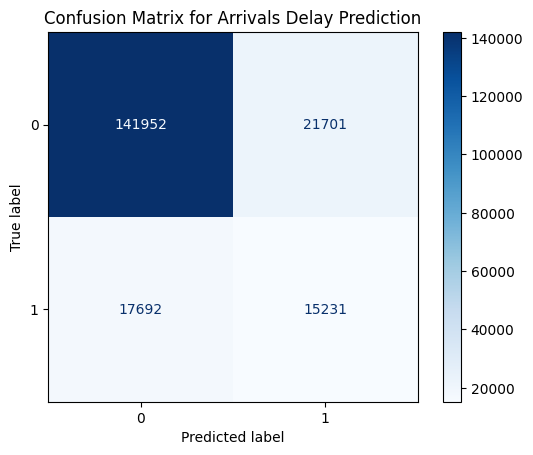

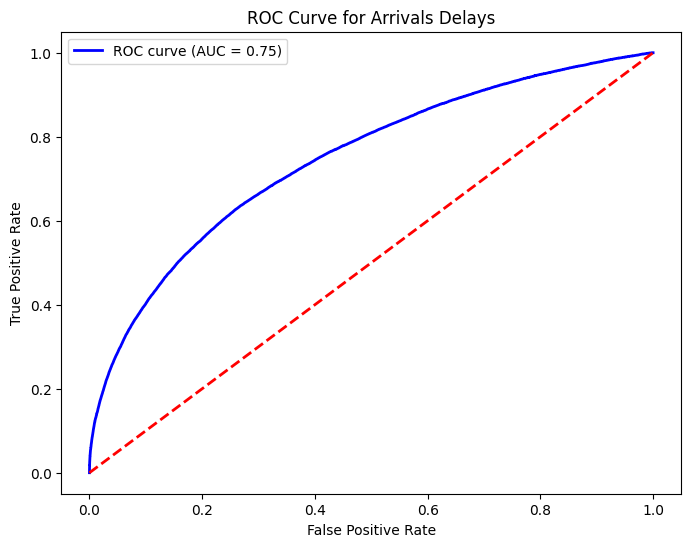

In [ ]:
# Predict probabilities and classes on the test sets
arr_y_pred_proba = rf_arr_model.predict_proba(atl_arrs_X_test)
arr_delay_probabilities = arr_y_pred_proba[:, 1]
arr_y_pred = rf_arr_model.predict(atl_arrs_X_test)

# Evaluate the model using accuracy, precision, recall, ROC AUC, and PR AUC
# Arrivals
arr_accuracy = accuracy_score(atl_arrs_y_test, arr_y_pred)
arr_precision = precision_score(atl_arrs_y_test, arr_y_pred)
arr_recall = recall_score(atl_arrs_y_test, arr_y_pred)
arr_roc_auc = roc_auc_score(atl_arrs_y_test, arr_delay_probabilities)
arr_pr_auc = average_precision_score(atl_arrs_y_test, arr_delay_probabilities)

# Create confusion matrix
arr_cm = confusion_matrix(atl_arrs_y_test, arr_y_pred)

# Print results
print(" Arrivals Delay Prediction Metrics:")
print(f"Accuracy: {arr_accuracy:.4f}")
print(f"Precision: {arr_precision:.4f}")
print(f"Recall: {arr_recall:.4f}")
print(f"ROC AUC: {arr_roc_auc:.4f}")
print(f"PR AUC: {arr_pr_auc:.4f}")
print("\nDetailed Classification Report for Arrivals:")
print(classification_report(atl_arrs_y_test, arr_y_pred))

# Calculate KS score for departure delay predictions
arr_ks_score = ks_score(atl_arrs_y_test, arr_delay_probabilities)

# Print the KS score
print(f"KS Score for Arrivals Delay Predictions: {arr_ks_score:.4f}")

from sklearn.metrics import ConfusionMatrixDisplay

# Visualize the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=arr_cm).plot(cmap='Blues')
plt.title("Confusion Matrix for Arrivals Delay Prediction")
plt.show()

# Plot the ROC curve
fpr, tpr, _ = roc_curve(atl_arrs_y_test, arr_delay_probabilities)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {arr_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Arrivals Delays')
plt.legend(loc="best")
plt.show()

## Output

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Departures
# Extract flight ID and actual departure delay label, and rename column for clarity
index1 = atl_deps_complete_e[['flight_id','DEP_DEL15']]
index1 = index1.rename(columns = {'DEP_DEL15':'DEP_actual'})

# Extract features for evaluation (exclude target and ID columns)
atl_deps_Xc = atl_deps_complete_e.drop(columns=['DEP_DEL15','ARR_DEL15','flight_id'], axis=1)
atl_deps_Xc_o = atl_deps_complete_o.drop(columns=['DEP_DEL15','flight_id'], axis=1)

# Make predictions using the trained random forest model
predictions = rf_dep_model.predict(atl_deps_Xc)

# Get predicted probabilities for the positive class (DEP_actual = 1)
probas = rf_dep_model.predict_proba(atl_deps_Xc)[:,1]

# Combine features, actual labels, predictions, and probabilities into a single DataFrame to use in visualization aspect of project
atl_deps = pd.concat([atl_deps_Xc_o, index1, pd.Series(predictions, name='DEP_predicted'), pd.Series(probas, name = 'DEP_probability')], axis=1)

# Arrivals
# Extract flight ID and actual departure delay label, and rename column for clarity
index2 = atl_arrs_complete_e[['flight_id','ARR_DEL15']]
index2 = index2.rename(columns = {'ARR_DEL15':'ARR_actual'})

# Extract features for evaluation (exclude target and ID columns)
atl_arrs_Xc = atl_arrs_complete_e.drop(columns=['DEP_DEL15','ARR_DEL15','flight_id'], axis=1)
atl_arrs_Xc_o = atl_arrs_complete_o.drop(columns=['DEP_DEL15','flight_id'], axis=1)

# Make predictions using the trained random forest model
predictions1 = rf_arr_model.predict(atl_arrs_Xc)

# Get predicted probabilities for the positive class (ARR_actual = 1)
probas1 = rf_arr_model.predict_proba(atl_arrs_Xc)[:,1]

# Combine features, actual labels, predictions, and probabilities into a single DataFrame to use in visualization aspect of project
atl_arrs = pd.concat([atl_arrs_Xc_o, index2, pd.Series(predictions1, name='ARR_predicted'), pd.Series(probas1, name = 'ARR_probability')], axis=1)


In [56]:
#del atl_deps, atl_arrs

In [ ]:
# Create csv files of ATL departure delay predictions
atl_deps.to_csv('atl_deps.csv', index=False)
atl_arrs.to_csv('atl_arrs.csv', index=False)

# Create parquet files of ATL arrival delay predictions
atl_deps.to_parquet('atl_deps.parquet', index=False)
atl_arrs.to_parquet('atl_arrs.parquet', index=False)